# 0.0 Import modules

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

from itertools import product as prod
from collections import defaultdict

from scipy import stats as ss

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from imblearn import combine as c
from imblearn import under_sampling as u_sampl

## 0.1 Problema

Uma seguradora de planos de saúde pretende passar a vender, também, seguros de automóveis.

A seguradora realizou pesquisa com cerca de 380.000 clientes para saber se teriam interesse, ou não, em contrtar o novo seguro. Todos os clientes responderam.

A seguradora selecionou cerca de 127.000 potenciais clientes para participar de uma campanha. Este grupo receberá a oferta de adesão ao seguro de automóvel via ligação telefônica.

**Problema**: o time de vendas tem condições de ligar para, somente, 20.000 pessoas. Como selecionar, dentre os potenciais clientes, aqueles que tem maior probabilidade de adquirir o seguro?

O *relatório* deve responder às seguintes questões:

1. Fornecer *insights* sobre os atributos mais relevantes de clientes interessados em adquirir o seguro.

2. Qual porcentagem dos potenciais clientes interessados o time de vendas vai conseguir aontatar fazendo 20.000 ligações?

3. Se o time de vendas fizer 40.000 ligações, qual será a porcentagem de clientes interessados contatada?

4. Quantas ligações o time de vendas precisariaria fazer para contatar 80% dos potenciais clientes interessados?

## 0.2 Load data

The file "table.csv" contains only the train data. The test data is in a separate file, "test.csv", which was downloaded via Kaggle's API.

In [2]:
home_path = "/home/marcos/Documentos/comunidade_DS/pa004_health_insurance_cross_sell/"

In [3]:
df_train_raw = pd.read_csv(home_path + 'data/table.csv')

In [4]:
df_train_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


A variável *response* é a variável resposta (target). As outras variáveis são as características (features).

## 0.3 Plano de solução

Após a limpeza dos dados, checarei algumas hipóteses (lista logo abaixo) que gerarão insights sobre a revelância dos atributos para o interesse dos clientes em adquirir o seguro de automóveis.

Utilizarei algum método de redução de dimensionalidade para encontrar quais atributos mais contribuem para a variância (Boruta).

Identificados os atributos, resta resolver um problema de clusterização: dividir os dados de teste em "interesse" e "não interesse", de acordo com os atributos daqueles dados. *Os dados de teste não tem a variável target, pois o time de vendas ainda não contatou aqueles potenciais clientes*. MiniBatchKMeans?

Contar os potenciais clientes classificados como "interesse" e responder às demais perguntas do relatório.

# 1.0 Análise descritiva dos dados

In [5]:
df1 = df_train_raw.copy()

## 1.1 Check and fill NA

In [6]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.2 Data types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

The features "driving_license", "previously_insured", "id", "region_code" and "policy_sales_channel" will remain as numerical variables. The only modification will be to write all of them as integers.

In [8]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

I don't know if it's better to separate the feature and target variables at this point. If I don't, I might alter the target values (by some mean, for example). Whereas if I do, I might, in the feature engineering process, change the order of the samples and create a mess! 

## 1.3 Descriptive Statistics

In [10]:
num_attr = df1.select_dtypes(include=('int64', 'float64'))
cat_attr = df1.select_dtypes(include=['object'])

### 1.3.1 Numerical attributes

In [11]:
aux1 = num_attr.drop(columns=['id', 'region_code', 'policy_sales_channel'])

num_desc = aux1.describe()
num_range = pd.DataFrame(aux1.apply(lambda x: x.max() - x.min()), columns=['range']).T
num_skew = pd.DataFrame(aux1.skew(), columns=['skew']).T
num_kurt = pd.DataFrame(aux1.kurt(), columns=['kurtosis']).T

num_stat = pd.concat([num_desc, num_range, num_skew, num_kurt]).T.drop(columns=['count'])
num_stat

,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
age,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,0.672539,-0.565655
driving_license,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,1.0,-21.595182,464.354302
previously_insured,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.0,0.167747,-1.971871
annual_premium,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087,34.004569
vintage,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,0.003030,-1.200688
response,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906,3.298788


Most customers answered that they are not interested in a car insurance. Only 12% answered 'yes' on the survey.

Also, most customers have a driving license.

Less than half of the customers were previously insured.

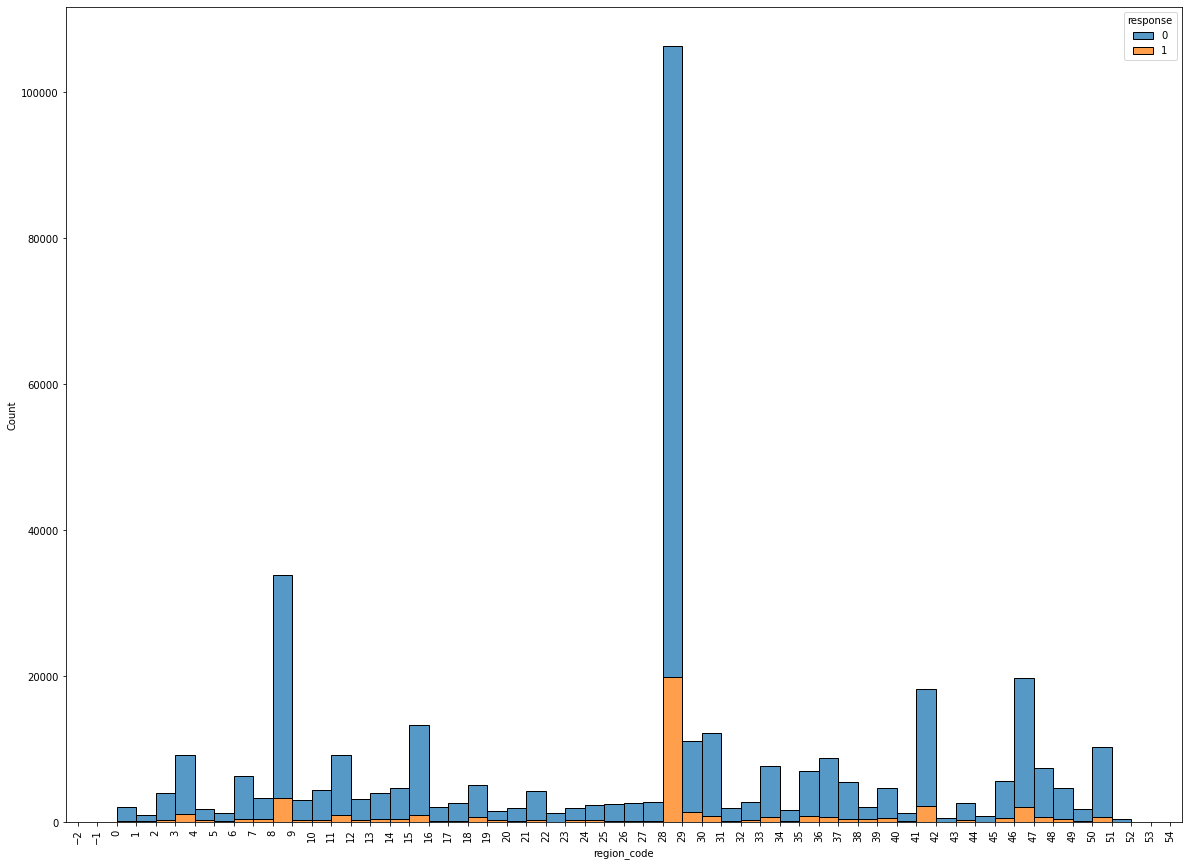

In [12]:
plt.figure(figsize=(20,15));

ax = plt.gca();

sns.histplot(data=num_attr, x='region_code', hue='response', multiple='stack', binwidth=1);
plt.xticks(rotation=90);
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));
plt.show();

### 1.3.2 Categorical attributes

Count number of categories in each feature

In [13]:
cat_attr.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

I will drop 'id' and 'policy_sales_channel' from the descriptive statistics analysis

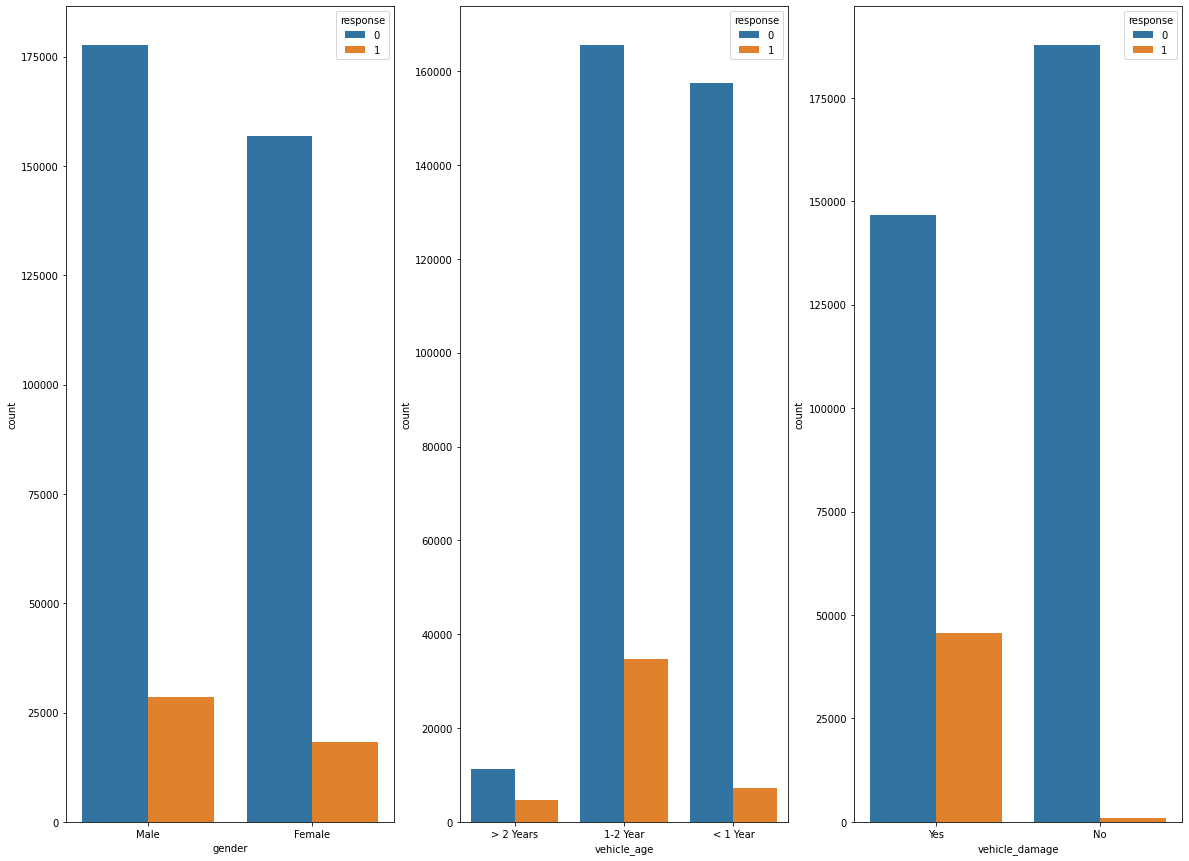

In [14]:
plt.figure(figsize=(20, 15))


plt.subplot(1, 3, 1)
sns.countplot(data=df1, x='gender', hue='response');#, multiple='stack');

plt.subplot(1, 3, 2)
sns.countplot(data=df1, x='vehicle_age', hue='response');#, multiple='stack');

plt.subplot(1, 3, 3)
sns.countplot(data=df1, x='vehicle_damage', hue='response');#, multiple='stack');

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1 Hipóteses

**1** Clientes sem licença tem menos probabilidade de adquirir seguro de automóvel.

**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.2 Hipóteses que serão testadas:

**1** Clientes sem licença tem meno probabilidade de adquirir seguro de automóvel.

<s>**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.</s>
Todos os clientes entrevistados são maiores de idade.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.3 Feature Engineering

I will derive some new features, representing customer loyalty, history and income estimate.

In [16]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0


In [17]:
def age_map(age):
    if age <= 25:
        return 1
    elif (age > 25) and (age <= 30):
        return 2
    elif (age > 30) and (age <= 35):
        return 3
    elif (age > 35) and (age <= 40):
        return 4
    elif (age > 40) and (age <= 50):
        return 5
    elif (age > 50) and (age <= 55):
        return 4
    elif (age > 55) and (age <= 65):
        return 3
    else:
        return 0

In [18]:
def vehicle_age_map (v_age):
    if v_age == '< 1 Year':
        return 3
    elif v_age == '1-2 Year':
        return 2
    else:
        return 0

In [19]:
weight_ages = df2['age'].map(age_map) + df2['vehicle_age'].map(vehicle_age_map)

In [20]:
weight_ages.unique()

array([5, 2, 4, 6, 7, 3, 0, 8, 1])

In [21]:
def damage_map(damage):
    if damage == 'Yes':
        return 1
    else:
        return 0

In [22]:
vehicle_hist = df2['vehicle_damage'].map(damage_map) + 1 - df2['previously_insured']

In [23]:
df2.insert(loc=len(df2.columns)-1, column='weight_ages', value=weight_ages)

In [24]:
df2.insert(loc=len(df2.columns)-1, column='vehicle_hist', value=vehicle_hist)

In [25]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,weight_ages,vehicle_hist,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,5,2,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,2,1,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,5,2,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,4,0,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,5,0,0


# 3.0 Filtragem das variáveis

In [26]:
df3 = df2.copy()

# 4.0 Análise Exploratória dos Dados

In [27]:
df4 = df3.copy()

In [28]:
num_attr = df4.select_dtypes(include=('int64', 'float64'))
cat_attr = df4.select_dtypes(include=['object'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

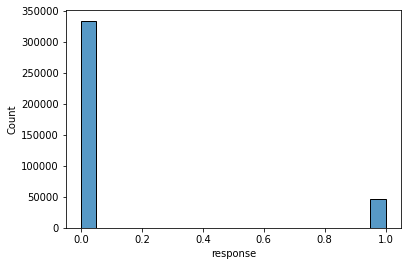

In [29]:
sns.histplot(data = df4, x='response');

### 4.1.2 Numerical Variables

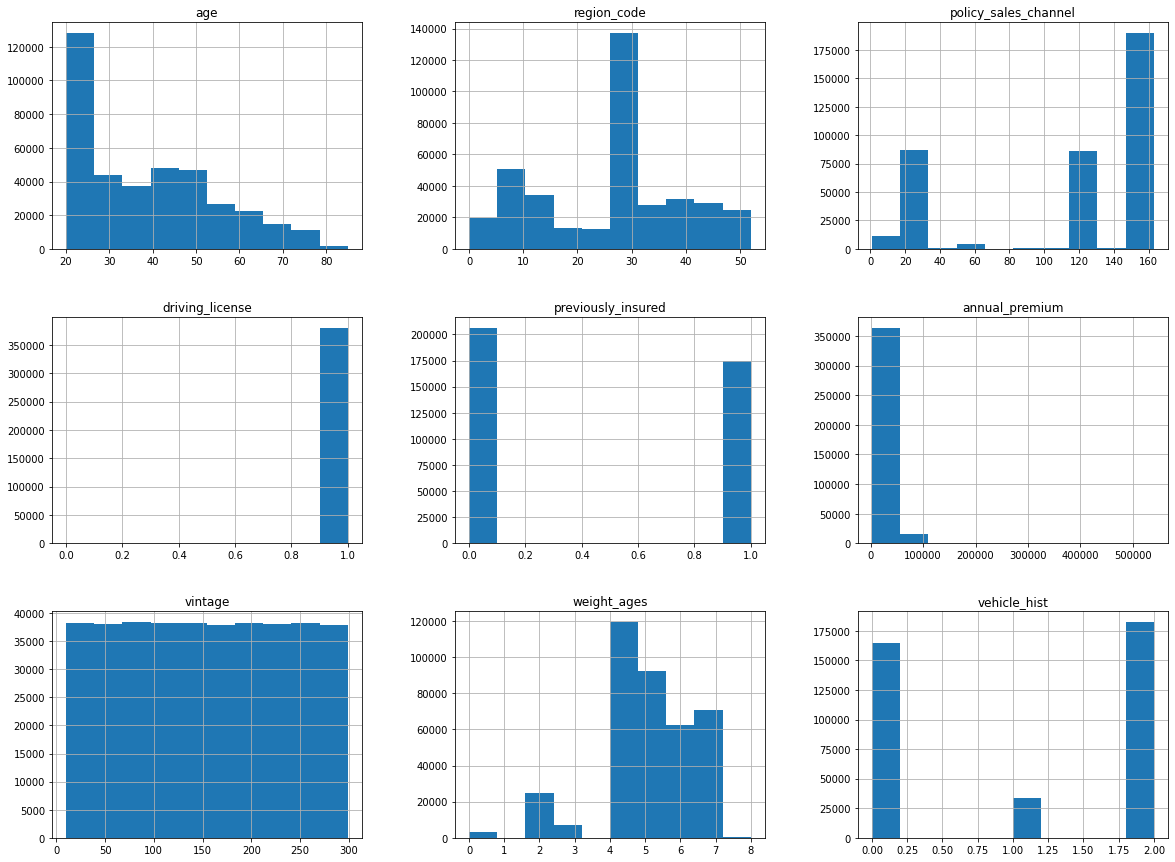

In [30]:
num_attr.drop(columns=['id', 'response']).hist(figsize=(20, 15));

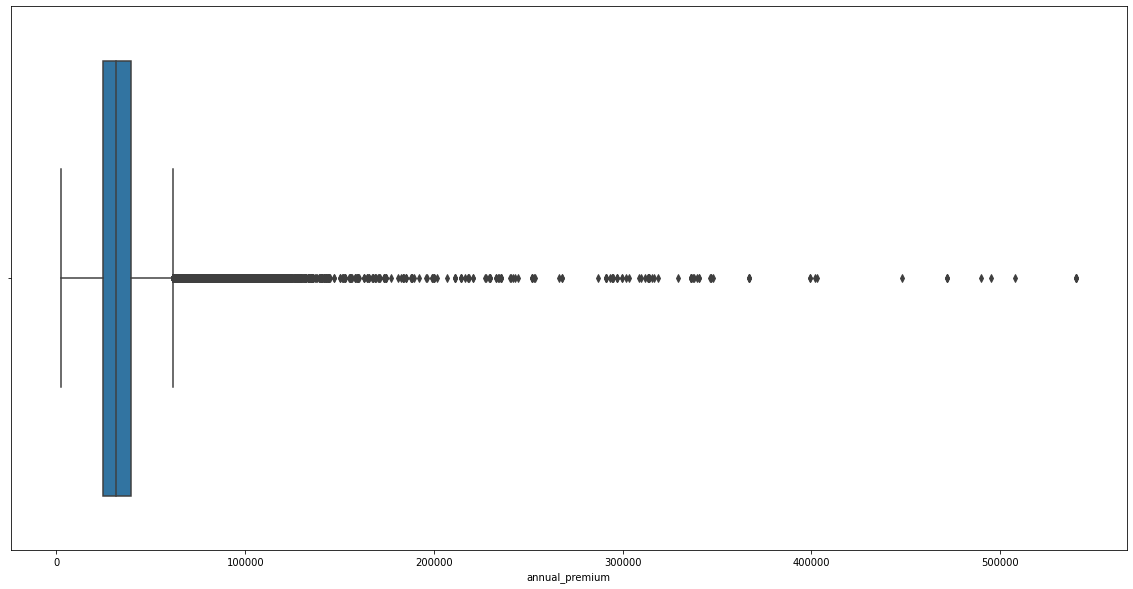

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(data=num_attr, x='annual_premium');

### 4.1.3 Categorical Variables

In [32]:
cat_attr.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


These variables will be displayed together with their percent counterparts

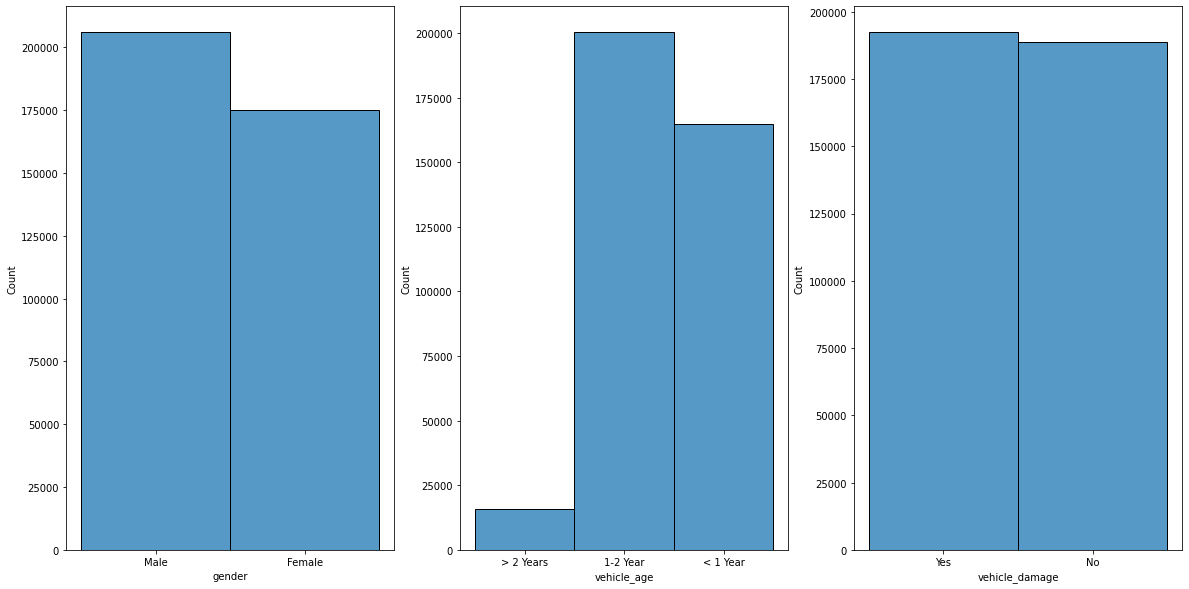

In [33]:
plt.figure(figsize=(20, 10))


plt.subplot(1, 3, 1)
sns.histplot(data=cat_attr, x='gender');

plt.subplot(1, 3, 2)
sns.histplot(data=cat_attr, x='vehicle_age');

plt.subplot(1, 3, 3)
sns.histplot(data=cat_attr, x='vehicle_damage');

## 4.2 Análise Bivariada

In [34]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'weight_ages',
       'vehicle_hist', 'response'],
      dtype='object')

### 4.2.1 Análise das variáveis

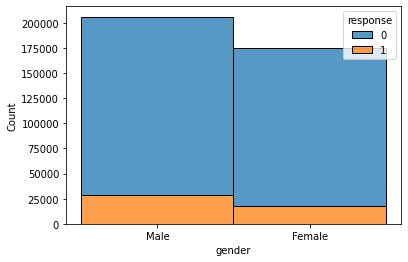

In [35]:
# gender
sns.histplot(data=df4, x='gender', hue='response', multiple='stack');

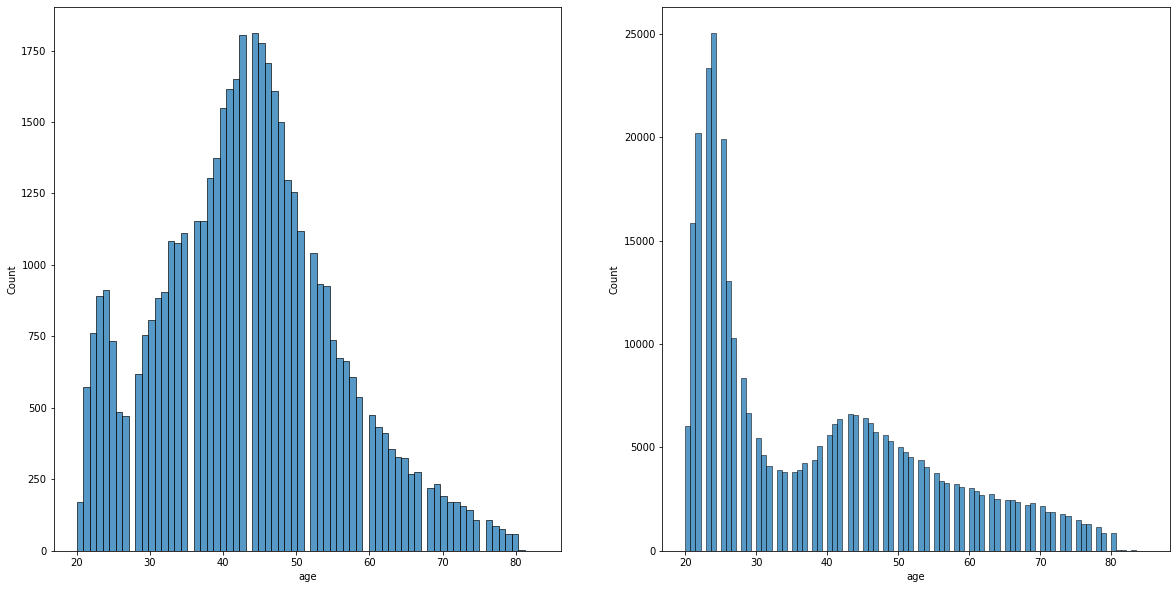

In [36]:
# age
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4[df4['response']==1], x='age');

plt.subplot(1, 2, 2)
sns.histplot(data=df4[df4['response']==0], x='age');

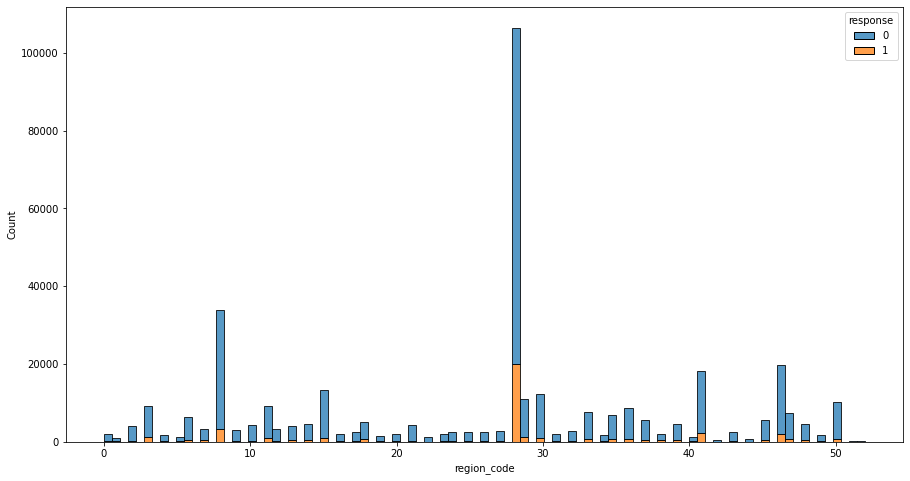

In [37]:
# region_code

plt.figure(figsize=(15, 8))

sns.histplot(data=df4, x='region_code', hue='response', multiple='stack');

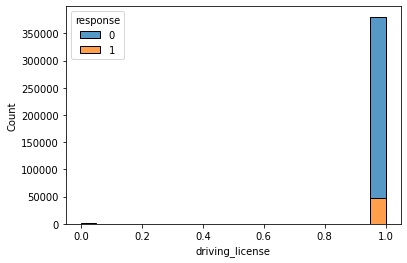

In [38]:
# driving_license

sns.histplot(data=df4, x='driving_license', hue='response', multiple='stack');

In [39]:
# vehicle_age

#plt.figure(figsize=(15, 8))
aux = df4.groupby('vehicle_age')['response'].mean().reset_index()
aux
#sns.histplot(data=aux, x='vehicle_age', hue='response', multiple='stack');

,vehicle_age,response
0,1-2 Year,0.173755
1,< 1 Year,0.043705
2,> 2 Years,0.293746


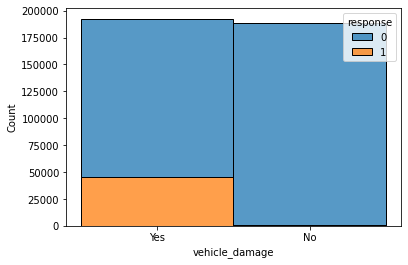

In [40]:
# vehicle_damage

#plt.figure(figsize=(15, 8))

sns.histplot(data=df4, x='vehicle_damage', hue='response', multiple='stack');

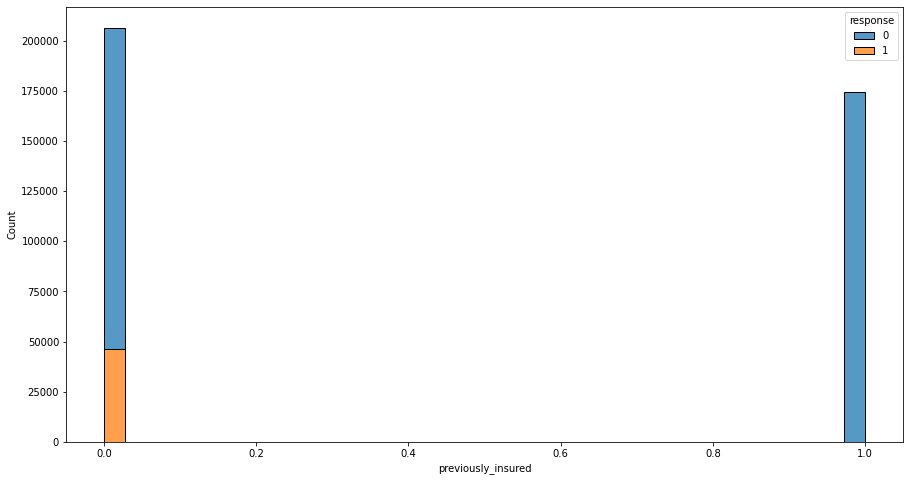

In [41]:
# previously_insured

plt.figure(figsize=(15, 8))

sns.histplot(data=df4, x='previously_insured', hue='response', multiple='stack');

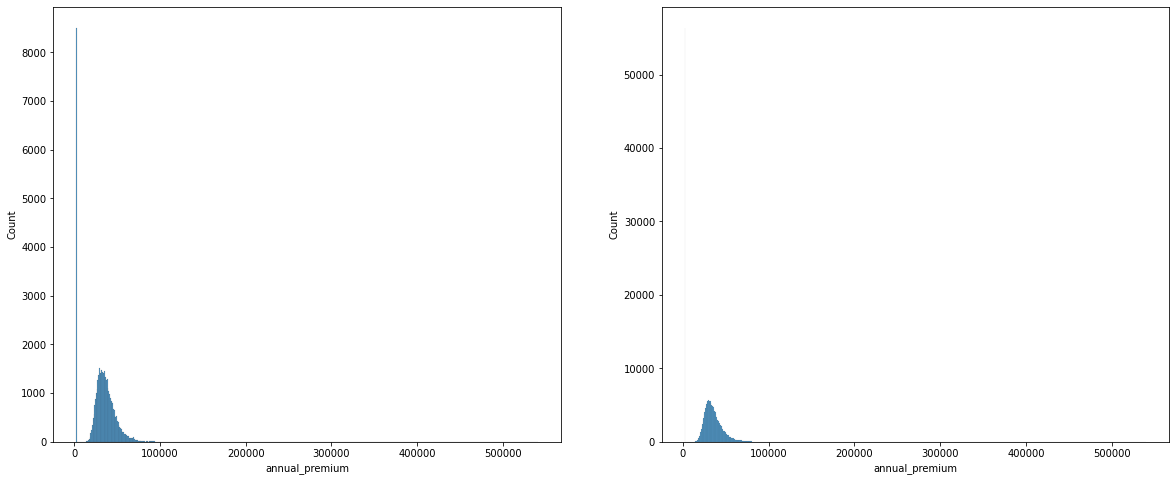

In [42]:
# annual_premium

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(data=df4[df4['response']==1], x='annual_premium');

plt.subplot(1, 2, 2)
sns.histplot(data=df4[df4['response']==0], x='annual_premium');

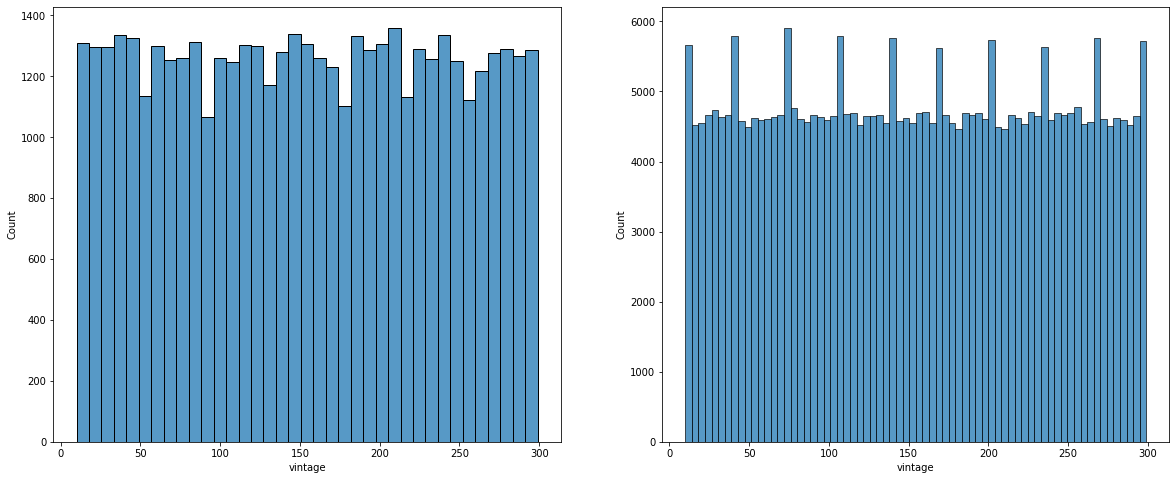

In [43]:
# vintage

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.histplot(data=df4[df4['response']==1], x='vintage');

plt.subplot(1, 2, 2)
sns.histplot(data=df4[df4['response']==0], x='vintage');

### 4.2.2 Teste de Hipóteses

In [44]:
df4_1 = df4[df4['response']==1]

**H1** Clientes sem licença tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

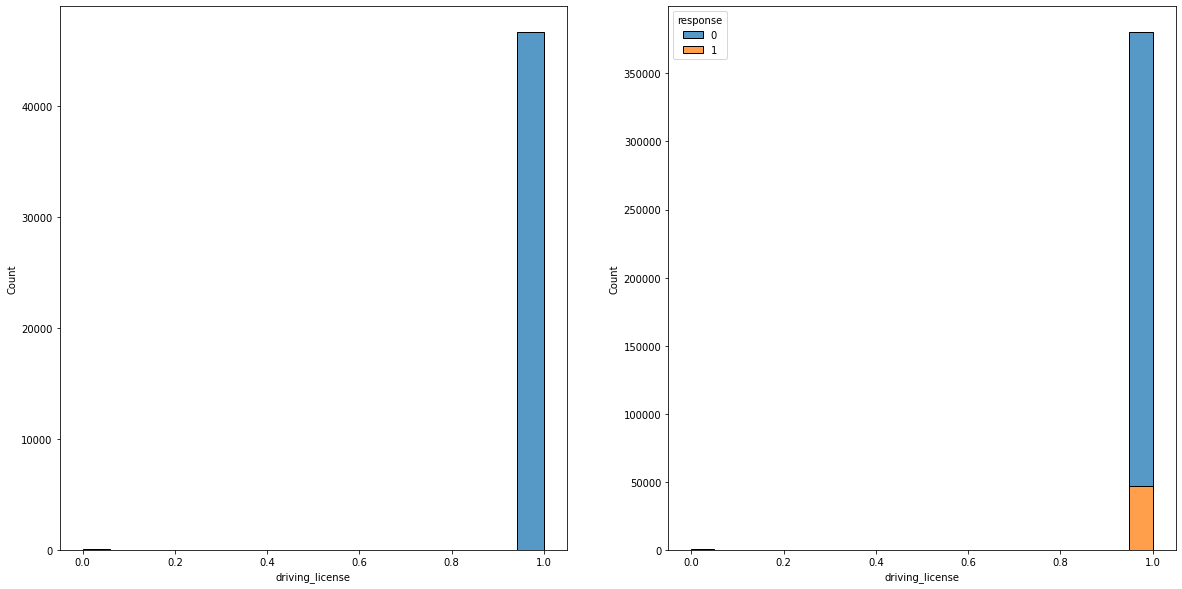

In [45]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='driving_license');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='driving_license', hue='response', multiple='stack');

**H2** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

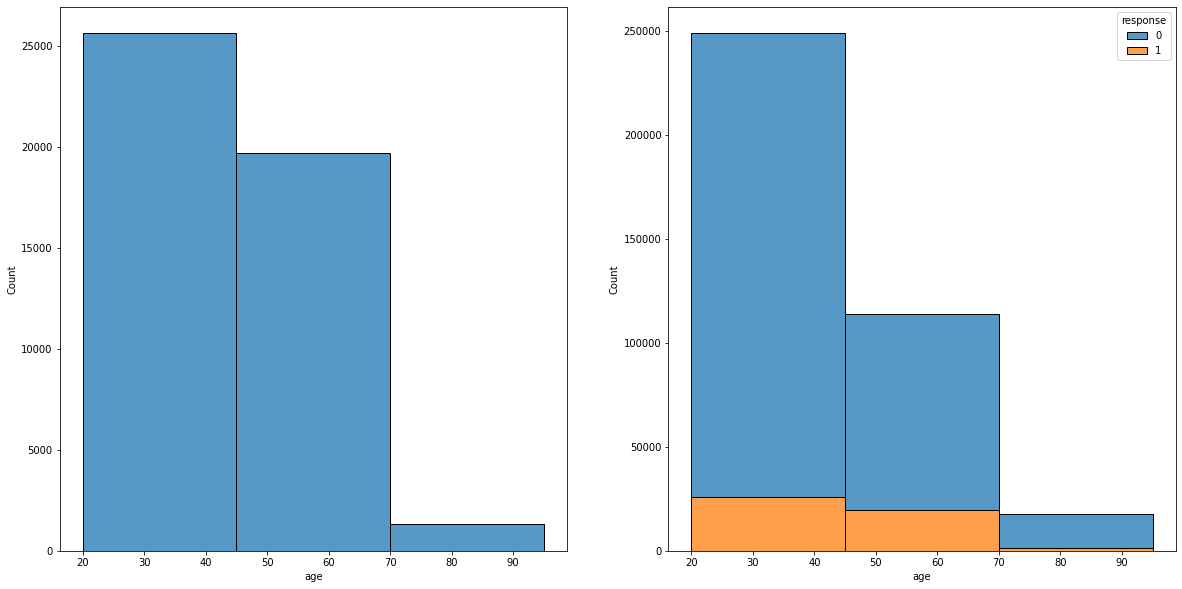

In [46]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='age', binwidth=25);

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='age', binwidth=25, hue='response', multiple='stack');

**H3** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Clientes homens tem maior probabilidade de adquirir seguro de automóvel.

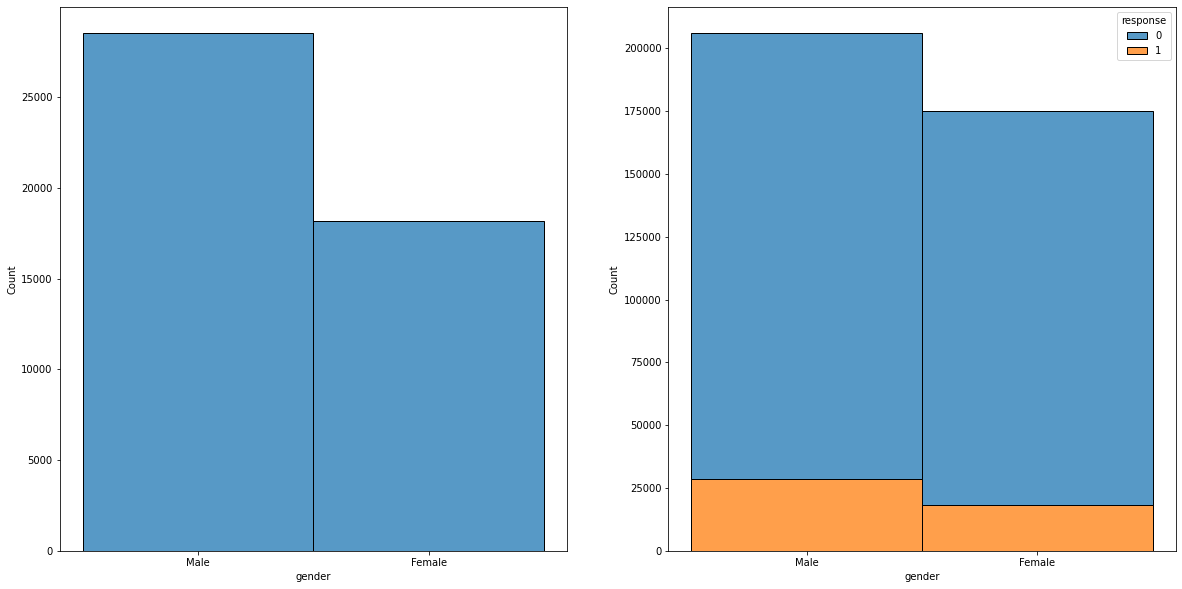

In [47]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='gender');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='gender', hue='response', multiple='stack');

**H4** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

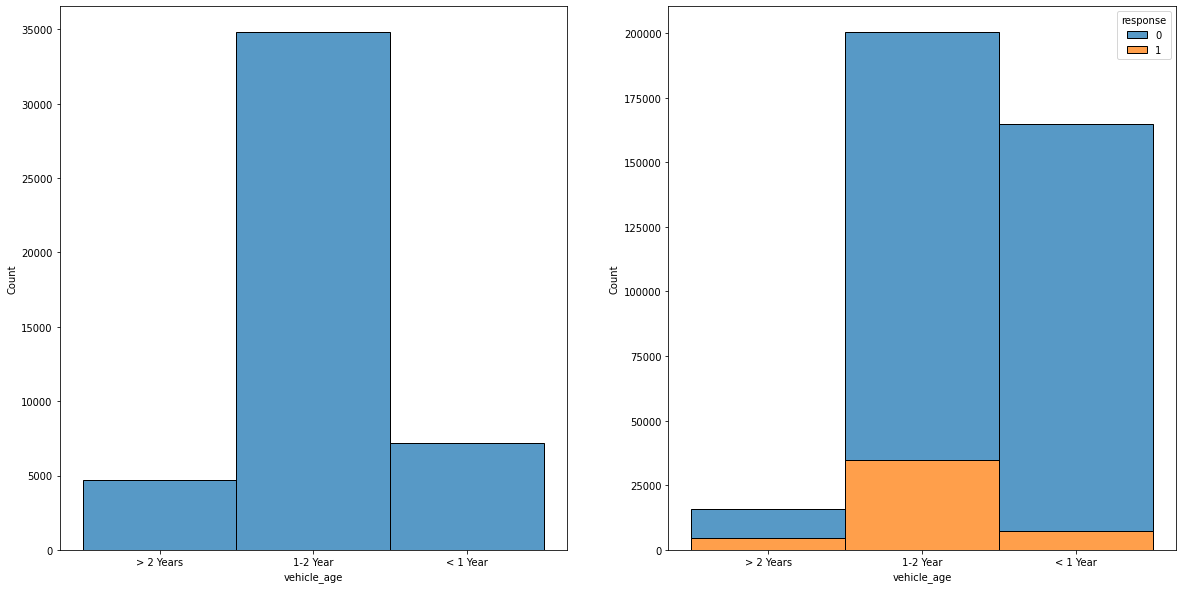

In [48]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='vehicle_age');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='vehicle_age', hue='response', multiple='stack');

**H5** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

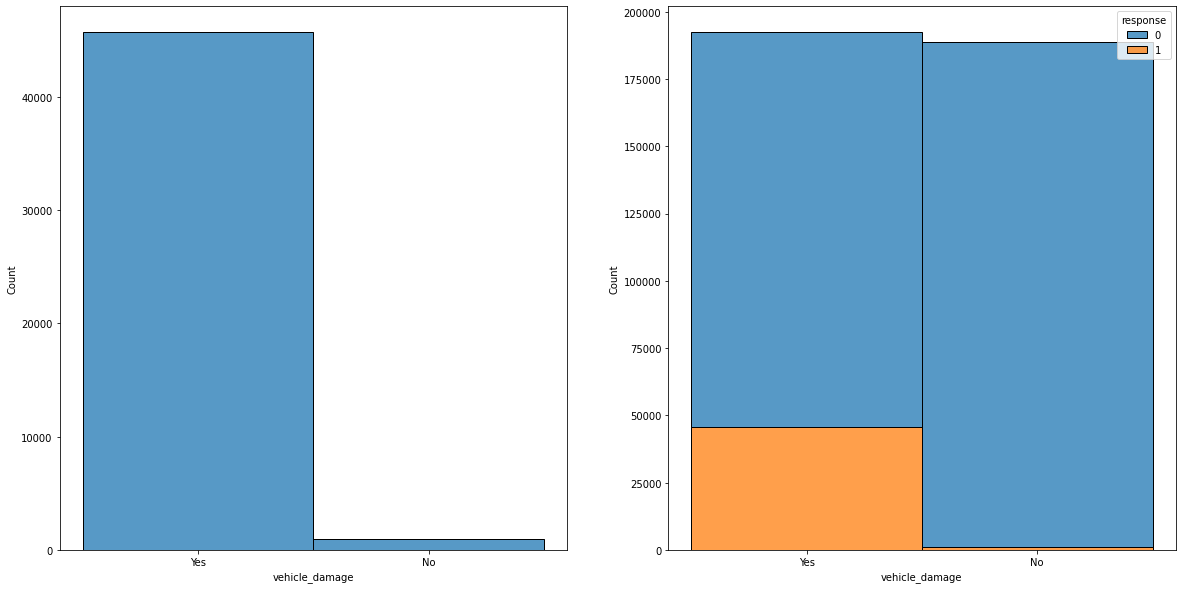

In [49]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
sns.histplot(data=df4_1, x='vehicle_damage');

plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='vehicle_damage', hue='response', multiple='stack');

**H6** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Não há correlação notável entre "vintage" e o seguro de automóvel.

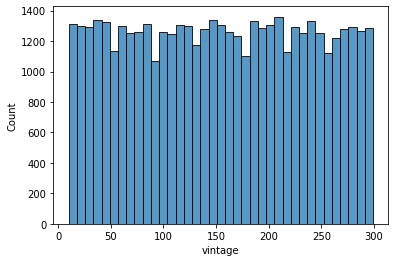

In [50]:
sns.histplot(data=df4_1, x='vintage');

**H7** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

**Falsa**

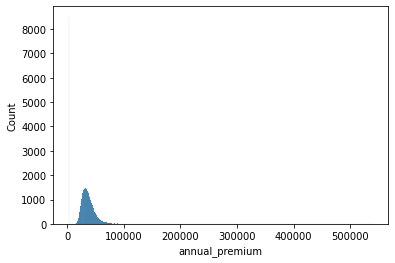

In [51]:
sns.histplot(data=df4_1, x='annual_premium');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

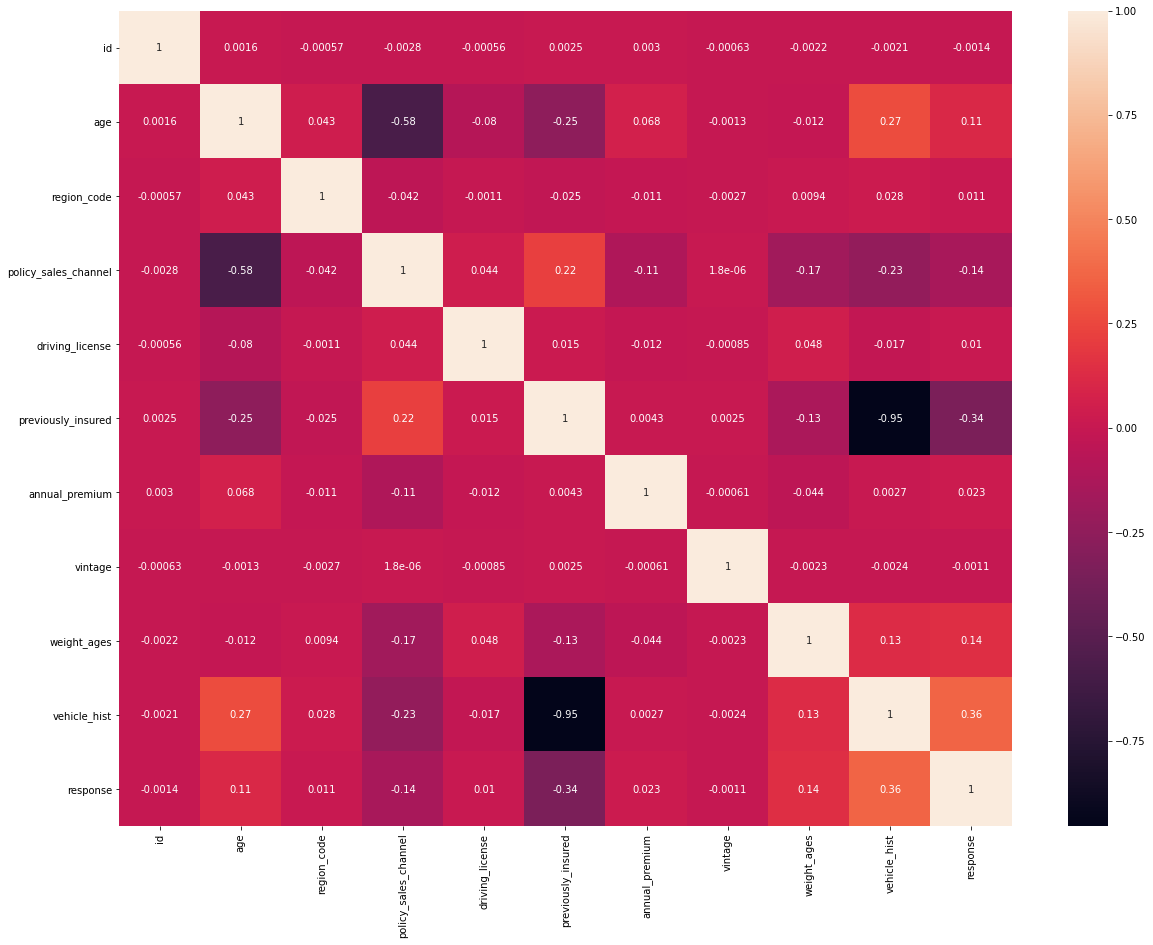

In [52]:
correl = num_attr.corr(method='pearson')
plt.figure(figsize=(20,15))
sns.heatmap(correl, annot=True);

### 4.3.2 Variáveis categóricas

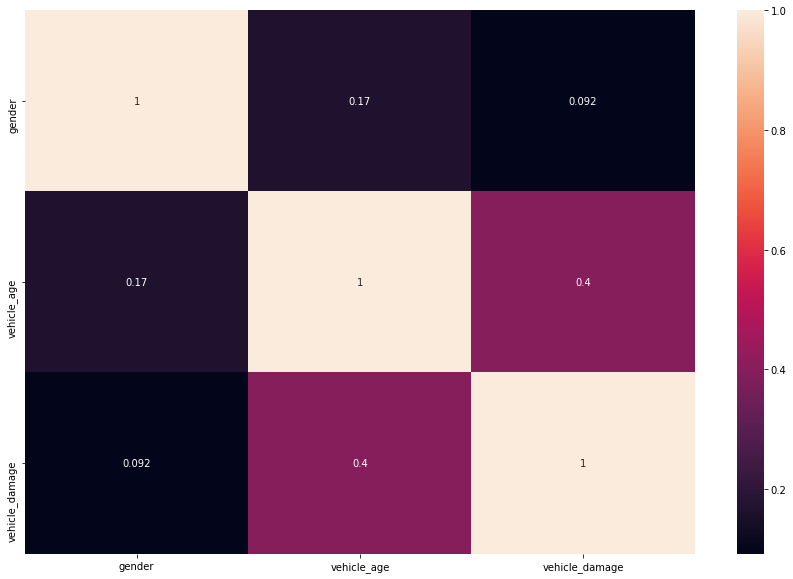

In [53]:
indexes = cat_attr.columns

#for scalability, I will create a function that returns Cramér's V correlation:

def cat_corr(x, y):
    '''Cross frequencies'''
    cont_mat = pd.crosstab(x, y).to_numpy()
    
    n = cont_mat.sum()
    r, k = cont_mat.shape
    
    '''chi square statistics'''
    chi2 = ss.chi2_contingency(cont_mat)[0]
    
    '''Corrected variables to compensate for bias:'''
    chi2corr = max(0, (chi2/n) - (k - 1)*(r - 1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    
    '''Cramérs V correlation'''''
    cramer_v = np.sqrt((chi2corr)/(min(k_corr-1, r_corr-1)))
    return cramer_v


d = defaultdict(list)
#d = {}
for x, y in prod(indexes, repeat=2):
    d[x].append(cat_corr(cat_attr[x],cat_attr[y]))

a = pd.DataFrame(d, index=indexes)

plt.figure(figsize=(15,10))
sns.heatmap(a, annot=True);

# 5.0 Data Preparation

In [54]:
df5 = df4.copy()

In [55]:
num_attr = df5.select_dtypes(include=('int64', 'float64'))
cat_attr = df5.select_dtypes(include=['object'])

In [56]:
num_attr.head()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,weight_ages,vehicle_hist,response
0,1,44,28,26,1,0,40454.0,217,5,2,1
1,2,76,3,26,1,0,33536.0,183,2,1,0
2,3,47,28,26,1,0,38294.0,27,5,2,1
3,4,21,11,152,1,1,28619.0,203,4,0,0
4,5,29,41,152,1,1,27496.0,39,5,0,0


In [57]:
cat_attr.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


## 5.1 Gender encoder

In [58]:
# gender: count_vectorizer()
gender_enc = CountVectorizer(lowercase=False)

# gender: "One-hot" encoder
gender = gender_enc.fit_transform(df5['gender']).toarray()
pickle.dump(gender_enc, open(home_path + 'encoders/gender_encoder.pkl', 'wb'))

In [59]:
gender_encoder = pickle.load(open(home_path + 'encoders/gender_encoder.pkl', 'rb'))

row = df5.loc[[0]]

row_gender = gender_encoder.transform(row['gender']).toarray()
df_row = pd.DataFrame(data=row_gender, columns=['gender_' + name for name in gender_encoder.get_feature_names()])
df7 = row.join(df_row)

df7

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,weight_ages,vehicle_hist,response,gender_Female,gender_Male
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,5,2,1,0,1
